<a href="https://colab.research.google.com/github/JovitorzZ/CP1--2Sem-Front-end/blob/main/CP1_Front_End_%26_Mobile_Development_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrantes + Objetivo:
---
* João Vitor Pires da Silva - RM: 556213
* Tiago Toshio Kumagai Gibo - RM: 556984
* Israel Dalcin Alves Diniz - RM: 554668
* Pablo Menezes Barreto - RM: 556389
* Matheus Hungaro Fidelis - RM: 555677
* Danilo Ramalho Silva - RM: 555183

---
## Objetivo (Notebook 2):
* Incluir as demais features do dataset no treinamento do modelo KMeans. Repetir as análises dos clusters e comparar os resultados entre:

* Modelo 1: utilizando somente a feature da sinopse vetorizada para treinamento do modelo

* Modelo 2: utilizando todas as features

* Escolher a melhor opção entre os 2 modelos, justificando a escolha.

In [1]:
import pandas as pd
import nltk
import numpy as np
import requests
from pprint import pprint
from bs4 import BeautifulSoup
import re
import json
from urllib.request import Request, urlopen
from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Carregando o DF do notebook 1

In [2]:
df = pd.read_csv('/content/CP1.csv', sep = ',')
df = df.drop(columns=['cluster'], axis=0)
df

,Title,Year,Rating,Genres,Synopsis,word_count,sinopse_no_stopwords
0,Barbie,2023,7.4,Aventura,viver na terra da barbie é ser um ser perfeito...,29,viver terra barbie perfeito lugar perfeito. me...
1,Um Sonho de Liberdade,1994,9.3,Drama,dois homens presos se reúnem ao longo de vário...,21,"dois homens presos reúnem longo vários anos, e..."
2,O Poderoso Chefão,1972,9.2,Policial,o patriarca idoso de uma dinastia do crime org...,20,patriarca idoso dinastia crime organizado tran...
3,Batman: O Cavaleiro das Trevas,2008,9.0,Ação,quando a ameaça conhecida como o coringa surge...,33,"ameaça conhecida coringa surge passado, causa ..."
4,O Poderoso Chefão II,1974,9.0,Policial,"em 1950, michael corleone, agora à frente da f...",41,"1950, michael corleone, agora frente família, ..."
...,...,...,...,...,...,...,...
481,Demon Slayer: Mugen Train - O Filme,2020,8.2,Animação,"tanjiro, inosuke e zenitsu são enviados pelo c...",37,"tanjiro, inosuke zenitsu enviados comando esqu..."
482,Gangues de Wasseypur,2012,8.2,Ação,um confronto entre sultão e shahid khan leva à...,25,confronto sultão shahid khan leva expulsão kha...
483,Na Natureza Selvagem,2007,8.0,Aventura,"depois de terminar a universidade, christopher...",20,"terminar universidade, christopher mccandless ..."
484,A Chantagem,2015,8.2,Policial,um homem toma medidas desesperadas para tentar...,22,homem toma medidas desesperadas tentar salvar ...


## Aplicando o TF-DF

In [3]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=.05, max_df=0.95, ngram_range=(1,2))
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['sinopse_no_stopwords'])

In [4]:
print(X.shape)
X.toarray()

(486, 15)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.69424093, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# K-Means

# Modelo 1

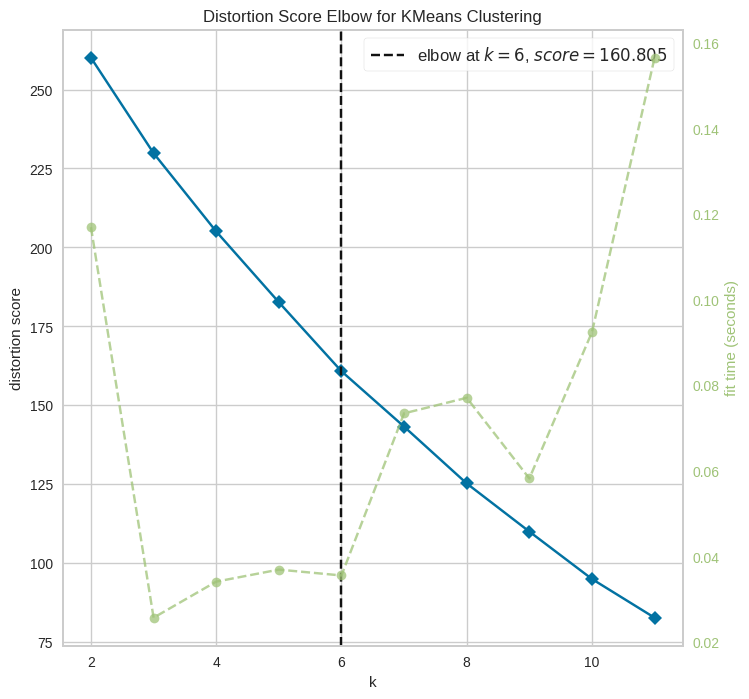

Número ideal de clusters (método Elbow): 6


In [5]:
model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(2, df.Genres.nunique()+1))

plt.figure(figsize=(8, 8))
visualizer.fit(X.toarray())
visualizer.show()


n_clusters_optimal = visualizer.elbow_value_
print(f"Número ideal de clusters (método Elbow): {n_clusters_optimal}")


kmeans_model1 = KMeans(n_clusters=n_clusters_optimal, random_state=42, n_init=10)
kmeans_model1.fit(X)


labels_model1 = kmeans_model1.labels_


df['cluster_model1'] = labels_model1


In [6]:
fig = px.bar(df['cluster_model1'].value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster (Modelo 1)',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

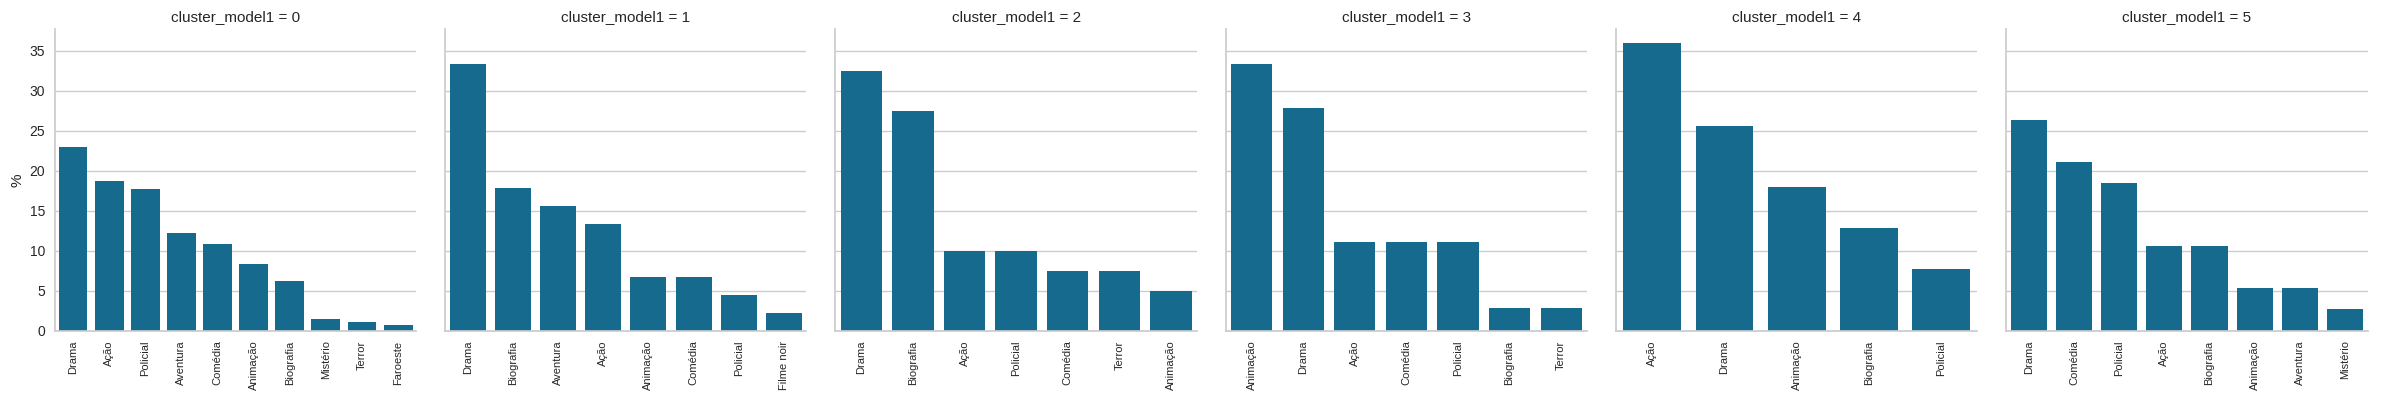

In [7]:
df_plot = df.groupby(['cluster_model1', 'Genres'])['Title'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'Title':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster_model1')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster_model1', '%'], ascending = False).groupby('cluster_model1').head(11)

fig = sns.catplot(
    data=df_plot, x="Genres", y = "%", col="cluster_model1",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

# Modelo 2

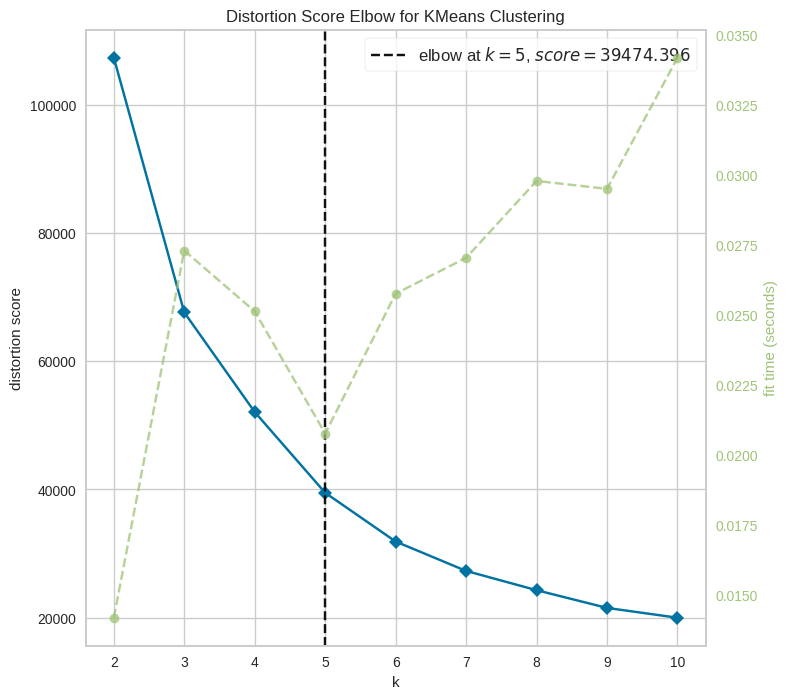

Número ideal de clusters para o Modelo 2 (método Elbow): 5


In [9]:
# Selecionar as features numéricas para incluir
numerical_features = df[['Year', 'Rating', 'word_count']]

# Converter a matriz esparsa X em um array denso
X_dense = X.toarray()

# Combinar as features numéricas e as features do TF-IDF
# Precisamos garantir que o número de linhas coincida, o que deve acontecer.
# Podemos usar np.hstack para empilhar os arrays horizontalmente
X_combined = np.hstack((numerical_features, X_dense))

# Instanciar o modelo de clustering e o visualizador para o Modelo 2
model2 = KMeans(random_state=42, n_init=10)
visualizer2 = KElbowVisualizer(model2, k=(2, 11)) # Vamos começar com um intervalo razoável para k

plt.figure(figsize=(8, 8))
visualizer2.fit(X_combined)        # Ajustar os dados combinados ao visualizador
visualizer2.show()                 # Finalizar e renderizar a figura

# Obter o número ideal de clusters para o Modelo 2
n_clusters_optimal2 = visualizer2.elbow_value_
print(f"Número ideal de clusters para o Modelo 2 (método Elbow): {n_clusters_optimal2}")

# Treinar o modelo KMeans com o número ideal de clusters para o Modelo 2
kmeans_model2 = KMeans(n_clusters=n_clusters_optimal2, random_state=42, n_init=10)
kmeans_model2.fit(X_combined)

# Obter os rótulos de clusters para o Modelo 2
labels_model2 = kmeans_model2.labels_

# Adicionar os rótulos de clusters ao dataframe
df['cluster_model2'] = labels_model2

In [10]:
fig = px.bar(df['cluster_model2'].value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster (Modelo 2)',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

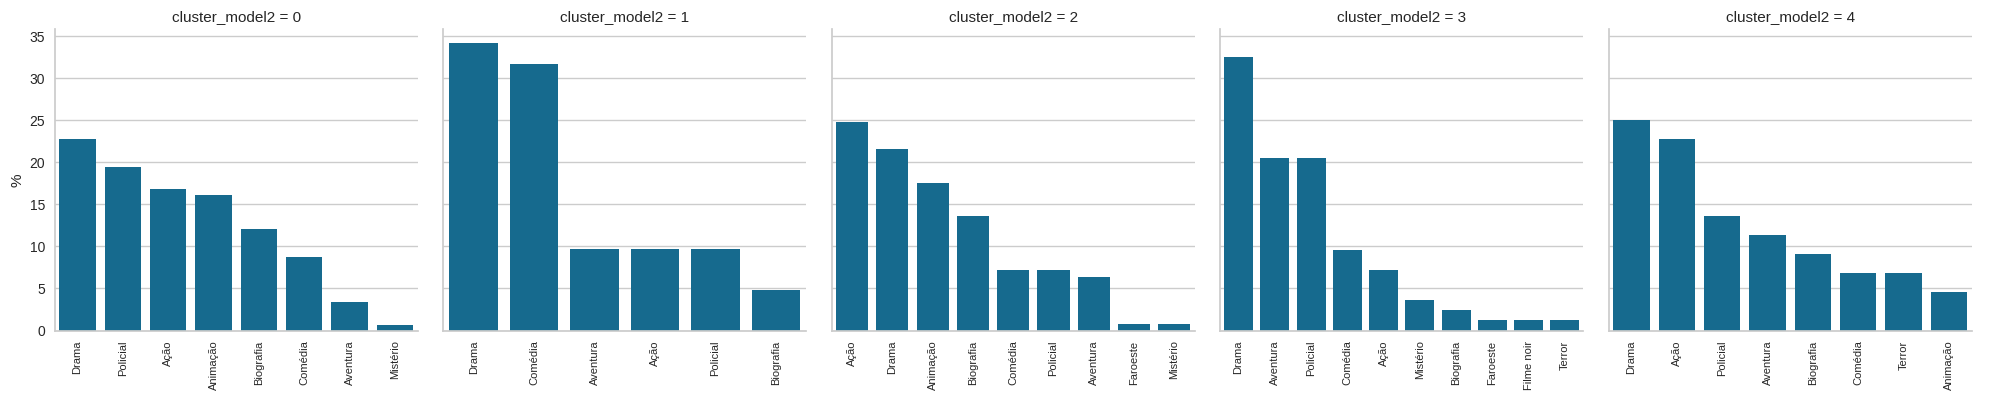

In [11]:
df_plot = df.groupby(['cluster_model2', 'Genres'])['Title'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'Title':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster_model2')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster_model2', '%'], ascending = False).groupby('cluster_model2').head(11)

fig = sns.catplot(
    data=df_plot, x="Genres", y = "%", col="cluster_model2",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

# Considerações finais

No Modelo 1, observamos que os clusters foram formados principalmente com base no conteúdo textual das sinopses. Isso resultou em agrupamentos que capturam semelhanças temáticas e narrativas entre os filmes. No entanto, a exclusão de outras features importantes como ano, rating e contagem de palavras na sinopse pode limitar a granularidade e a precisão dos clusters em relação a outros aspectos dos filmes.

No Modelo 2, ao incorporar o ano de lançamento, a avaliação (rating) e a contagem de palavras na sinopse juntamente com a sinopse vetorizada, o modelo K-means teve mais informações para considerar na formação dos clusters. Isso pode levar a agrupamentos mais ricos e potencialmente mais alinhados com as diferentes características que definem um filme. A análise da distribuição de gêneros dentro de cada cluster no Modelo 2 nos permite ver como a inclusão dessas features influenciou o agrupamento em comparação com o Modelo 1. Por exemplo, podemos observar se certos clusters no Modelo 2 agrupam filmes de anos específicos, com ratings semelhantes, ou com sinopses de tamanhos parecidos, além das semelhanças na sinopse em si.


**Conclusão**

Considerando o objetivo de um sistema de recomendação de filmes, que busca oferecer sugestões relevantes e personalizadas aos usuários, **o Modelo 2 se apresenta como a melhor opção.** A inclusão de features como ano, rating e contagem de palavras no processo de clustering fornece ao modelo uma visão mais completa das características que influenciam a preferência do usuário. Isso permite a formação de clusters mais ricos e discriminativos, que podem ser utilizados de forma mais eficaz para identificar filmes semelhantes aos que o usuário gostou ou que se encaixam em seu perfil de preferência mais amplo do que apenas o conteúdo da sinopse. Portanto, para um sistema de recomendação que visa maior precisão e personalização, a abordagem do Modelo 2 é superior.